In [2]:
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt
import os
from keras.layers import Conv2D,Rescaling,RandomFlip,RandomRotation,Dense,Flatten,MaxPooling2D,InputLayer,Dropout,RandomZoom,RandomBrightness,RandomTranslation,LeakyReLU,Conv2DTranspose,BatchNormalization,Reshape,Embedding,Concatenate,Input
from keras.losses import SparseCategoricalCrossentropy,BinaryCrossentropy
from keras.utils import plot_model
from keras import Sequential
from keras.optimizers import Adam,SGD,RMSprop
from pathlib import Path
import numpy as np
import copy
from random import randint
import keras
import time
import math

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
preprocess = lambda x,y: ((x-127.5)/127.5 ,y)
display_model = lambda x: plot_model(x,show_shapes=True)

In [4]:
no_of_class = 102
IMG_SIZE = (100,100)
BATCH = 8

train = tf.keras.utils.image_dataset_from_directory('../102_flowers_dataset/train/',image_size=IMG_SIZE,shuffle=True,batch_size=BATCH)
test = tf.keras.utils.image_dataset_from_directory('../102_flowers_dataset/valid/',image_size=IMG_SIZE,shuffle=True,batch_size=BATCH)

train = train.map(preprocess)
test = test.map(preprocess)

Found 6552 files belonging to 102 classes.


2024-10-01 10:53:06.148908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-01 10:53:06.149020: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-01 10:53:06.149064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-01 10:53:06.314726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-01 10:53:06.314851: I external/local_xla/xla/stream_executor

Found 818 files belonging to 102 classes.


2024-10-01 10:53:09.547048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


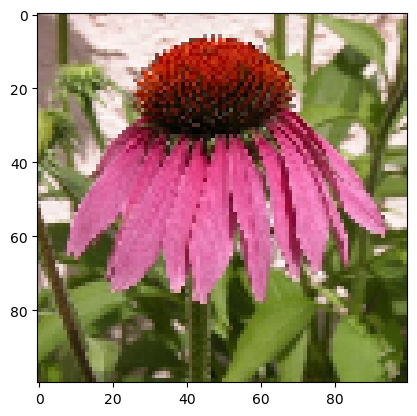

In [5]:
# sampling

for i,j in train.take(1):
    plt.imshow((i[0].numpy()+1)/2.0)

In [6]:
def discriminator_block(filters:int,name:int,input:keras.Layer) -> keras.Layer:
    
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=2, padding='same', name=f'Convo_{name}')(input)
    x = LeakyReLU(name=f'Leaky_{name}')(x)
    x = Dropout(0.1,name=f'Dropout_{name}')(x)
    
    return x
    
def dense_block(filters:list,input: keras.Layer) -> keras.Layer:
    
    x = Dense(filters[0],name=f'Dense_{1}',activation='relu')(input)
    
    for i,j in enumerate(filters[1:]):
        x = Dense(j,name=f'Dense_{i+2}',activation='relu')(x)
    
    return x
    
def make_discriminator_cond(img: tuple[int],no_of_class:int) -> keras.Model:
    label_input = Input(shape=(1,),name='label_input')
    
    l = Embedding(no_of_class,512,name='label_embedding')(label_input)
    l = Dense(np.prod(img),name='label_dense')(l)
    l = Reshape((img[0], img[1],1),name='label_Reshape')(l)
    
    img_input = Input(shape=(img[0],img[1],3),name='image_input')

    
    merge = Concatenate(name='concatenate')([img_input,l])
    
    x = discriminator_block(32,1,merge)
    x = discriminator_block(64,2,x)
    x = discriminator_block(128,3,x)
    x = discriminator_block(256,4,x)
    x = Flatten(name='flatten')(x)
    
    x = dense_block([128,64,32,16,8],x)

    x = Dense(1, activation='sigmoid', name='final')(x)
    
    discriminator = tf.keras.Model([img_input,label_input],x,name='Conditional_Discriminator')
    
    return discriminator


In [7]:
make_discriminator_cond(IMG_SIZE,no_of_class).summary()

Model: "Conditional_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 512)    │     52,224 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 10000)  │  5,130,000 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_Reshape       │ (None, 100, 100,  │          0 │ label_dense[0][0] │
│ (Reshape)           │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 100,  │          0 │ image_input[0][0… │
│ (Concatenate)       │ 4)                │            │ label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_1 (Conv2D)    │ (None, 50, 50,    │      1,184 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_1 (LeakyReLU) │ (None, 50, 50,    │          0 │ Convo_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 50, 50,    │          0 │ Leaky_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_2 (Conv2D)    │ (None, 25, 25,    │     18,496 │ Dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_2 (LeakyReLU) │ (None, 25, 25,    │          0 │ Convo_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_2 (Dropout) │ (None, 25, 25,    │          0 │ Leaky_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_3 (Conv2D)    │ (None, 13, 13,    │     73,856 │ Dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_3 (LeakyReLU) │ (None, 13, 13,    │          0 │ Convo_3[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_3 (Dropout) │ (None, 13, 13,    │          0 │ Leaky_3[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_4 (Conv2D)    │ (None, 7, 7, 256) │    295,168 │ Dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_4 (LeakyReLU) │ (None, 7, 7, 256) │          0 │ Convo_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_4 (Dropout) │ (None, 7, 7, 256) │          0 │ Leaky_4[0][0]   

 Total params: 7,187,697 (27.42 MB)

 Trainable params: 7,187,697 (27.42 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#display_model(make_discriminator_cond(IMG_SIZE,no_of_class))

In [8]:
def prime_factors(n:int) -> list:
    result = []
    
    for i in range(2,n//2+1):
        while n%i==0:
            n=n//i
            result.append(i)   

    return result

prime_factors(IMG_SIZE[0])

[2, 2, 5, 5]

In [9]:
latent_dim = np.array([10,10,512])
noise_shape = 256

def upsample_block(filters:int,name:int,strides:int,kernel:int,input:keras.Layer) -> keras.Layer:
    
    x = Conv2DTranspose(filters,(kernel,kernel),strides=strides,padding='same', name=f'conv_{name}')(input)
    x = BatchNormalization(name=f'norm_{name}')(x)
    x = LeakyReLU(name=f'leaky_{name}')(x)
    
    return x

def make_generator_cond(no_of_class:int,noise_shape:tuple[int],latent_dim:tuple[int]) -> keras.Model:
    
    label_input = Input(shape=(1,),name='label_input')
    l = Embedding(no_of_class,512,name='label_embedding')(label_input)
    l = Dense(np.cumprod(latent_dim)[-2],name='label_dense')(l)
    l = Reshape(np.append(latent_dim[:-1],[1]),name='label_Reshape')(l)
    
    noise_input = Input(shape=(noise_shape,),name='noise_input')
    n = Dense(np.prod(latent_dim),name='noise_dense')(noise_input)
    n = BatchNormalization(name='norm_noise')(n)
    n = LeakyReLU(name='leaky_noise')(n)
    n = Reshape(latent_dim,name='noise_reshape')(n)
    
    merge = Concatenate(name='concatenate')([n,l])
    
    x = upsample_block(filters=128,name=1,strides=2,kernel=3,input=merge)
    x = upsample_block(filters=128,name=2,strides=1,kernel=2,input=x)
        
    x = upsample_block(filters=128,name=3,strides=5,kernel=6,input=x)
    x = upsample_block(filters=128,name=4,strides=1,kernel=2,input=x)
    
    x = Conv2DTranspose(3,(3,3),strides=1,padding='same', name='final',activation='tanh')(x)
    
    generator = tf.keras.Model([noise_input,label_input],x,name='Conditional_Generator')
    
    return generator

In [10]:
make_generator_cond(no_of_class,noise_shape,latent_dim).summary()

Model: "Conditional_Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_input         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_dense (Dense) │ (None, 51200)     │ 13,158,400 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_noise          │ (None, 51200)     │    204,800 │ noise_dense[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 512)    │     52,224 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_noise         │ (None, 51200)     │          0 │ norm_noise[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 100)    │     51,300 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_reshape       │ (None, 10, 10,    │          0 │ leaky_noise[0][0] │
│ (Reshape)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_Reshape       │ (None, 10, 10, 1) │          0 │ label_dense[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 10,    │          0 │ noise_reshape[0]… │
│ (Concatenate)       │ 513)              │            │ label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1              │ (None, 20, 20,    │    591,104 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_1              │ (None, 20, 20,    │        512 │ conv_1[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_1 (LeakyReLU) │ (None, 20, 20,    │          0 │ norm_1[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2              │ (None, 20, 20,    │     65,664 │ leaky_1[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_2              │ (None, 20, 20,    │        512 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_2 (LeakyReLU) │ (None, 20, 20,    │          0 │ norm_2[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3              │ (None, 100, 100,  │    589,952 │ leaky_2[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 14,784,615 (56.40 MB)

 Trainable params: 14,681,191 (56.00 MB)

 Non-trainable params: 103,424 (404.00 KB)

In [11]:
#display_model(make_generator_cond(no_of_class,noise_shape,latent_dim))

In [11]:
class GAN(tf.keras.Model):
    def __init__(self, latent_dim:np.ndarray,noise_shape:int,img_shape:tuple[int]) -> None:
        super(GAN,self).__init__()
        self.latent_shape = latent_dim
        self.noise_shape = noise_shape
        self.img = img_shape
        self.generator = make_generator_cond(no_of_class,self.noise_shape,self.latent_shape)
        self.discriminator = make_discriminator_cond(self.img,no_of_class)
        self.gen_loss = tf.keras.metrics.Mean(name="generator_loss")
        self.dis_loss = tf.keras.metrics.Mean(name="discriminator_loss")
        
    @property
    def metrics(self):
        return [self.gen_loss,self.dis_loss]
    
    def compile(self,gen_opt,dis_opt,gen_loss_func,dis_loss_func):
        super(GAN,self).compile()
        self.gen_opt = gen_opt
        self.dis_opt = dis_opt
        self.gen_loss_func = gen_loss_func
        self.dis_loss_func = dis_loss_func
        
    def call(self,noise,label):
        gen_img = self.generator([noise,label],training=False)
        return gen_img
    
    @tf.function
    def train_step(self, image):
        img, label = image
        noise = tf.random.normal([BATCH, self.noise_shape])
        
        label = tf.expand_dims(label,axis=-1)
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated = self.generator([noise,label],training=True)
        
            real = self.discriminator([img,label],training=True)
            fake = self.discriminator([generated,label],training=True)
            gen_loss_ =  self.gen_loss_func(fake)
            dis_loss_ = self.dis_loss_func(real,fake)
        
        gradients_g = gen_tape.gradient(gen_loss_, self.generator.trainable_variables)
        gradients_d = disc_tape.gradient(dis_loss_, self.discriminator.trainable_variables)

        self.gen_opt.apply_gradients(zip(gradients_g, self.generator.trainable_variables))
        self.dis_opt.apply_gradients(zip(gradients_d, self.discriminator.trainable_variables))

        self.gen_loss.update_state(gen_loss_)
        self.dis_loss.update_state(dis_loss_)
        
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self):
        try:
            self.generator.save('../saved_weights/cgan/gen.keras')
        except:
            print('Error saving the generator')
        
        try:
            self.discriminator.save('../saved_weights/cgan/dis.keras')
        except:
            print('Error saving the discriminator')
            
    def load_model(self):
        try:
            self.generator.load_weights('../saved_weights/cgan/gen.keras')
            print('Loaded the generator')
        except:
            print('Error loading the generator')
        
        try:
            self.discriminator.load_weights('../saved_weights/cgan/dis.keras')
            print('Loaded the discriminator')
            
        except:
            print('Error loading the discriminator')
                

In [12]:
gan = GAN(latent_dim,noise_shape,IMG_SIZE)

gen_opt = Adam(learning_rate=0.0005)
dis_opt = Adam(learning_rate=0.00001)

cross_entropy = BinaryCrossentropy()

def gen_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)


def dis_loss(real,fake):
    real_ = cross_entropy(tf.ones_like(real), real)
    fake_ = cross_entropy(tf.zeros_like(fake), fake)
    total = real_ + fake_
    return total

In [13]:
gan.compile(gen_opt,dis_opt,gen_loss,dis_loss)

In [15]:
gan.load_model()

Error loading the generator


2024-10-01 10:53:36.229768: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17280000 exceeds 10% of free system memory.


Error loading the discriminator


2024-10-01 10:53:36.570557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17280000 exceeds 10% of free system memory.


In [28]:
history=gan.fit(train,epochs=20)

Epoch 1/20


I0000 00:00:1727633995.253828   60631 service.cc:145] XLA service 0x7f077800aa90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727633995.254072   60631 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-09-29 23:49:55.586345: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-29 23:49:56.784903: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-09-29 23:50:14.238448: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1727634029.559901   60631 asm_compiler.cc:369] ptxas warning 

819/819 ━━━━━━━━━━━━━━━━━━━━ 87s 51ms/step - discriminator_loss: 1.3773 - generator_loss: 0.6992
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - discriminator_loss: 1.3863 - generator_loss: 0.6931
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - discriminator_loss: 1.3886 - generator_loss: 0.7024
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - discriminator_loss: 1.3863 - generator_loss: 0.6917
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - discriminator_loss: 1.3863 - generator_loss: 0.6922
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - discriminator_loss: 1.3863 - generator_loss: 0.6926
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - discriminator_loss: 1.3863 - generator_loss: 0.6929
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - discriminator_loss: 1.3863 - generator_loss: 0.6931
Epoch 9/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - discriminator_loss: 1.3863 - generator_loss: 0.6931
Epoch 10/20
819/819 ━━━━━━━━━━━━━━━━━━━

In [81]:
gan.save_model()

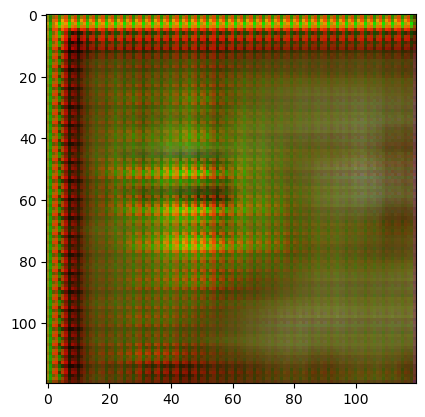

In [83]:
noise=  tf.random.normal([1, noise_shape],seed=randint(0,1000))
label = tf.Variable([10])

pred = gan(noise,label)
plt.imshow((pred[0, :, :, :]+1)/2.0)


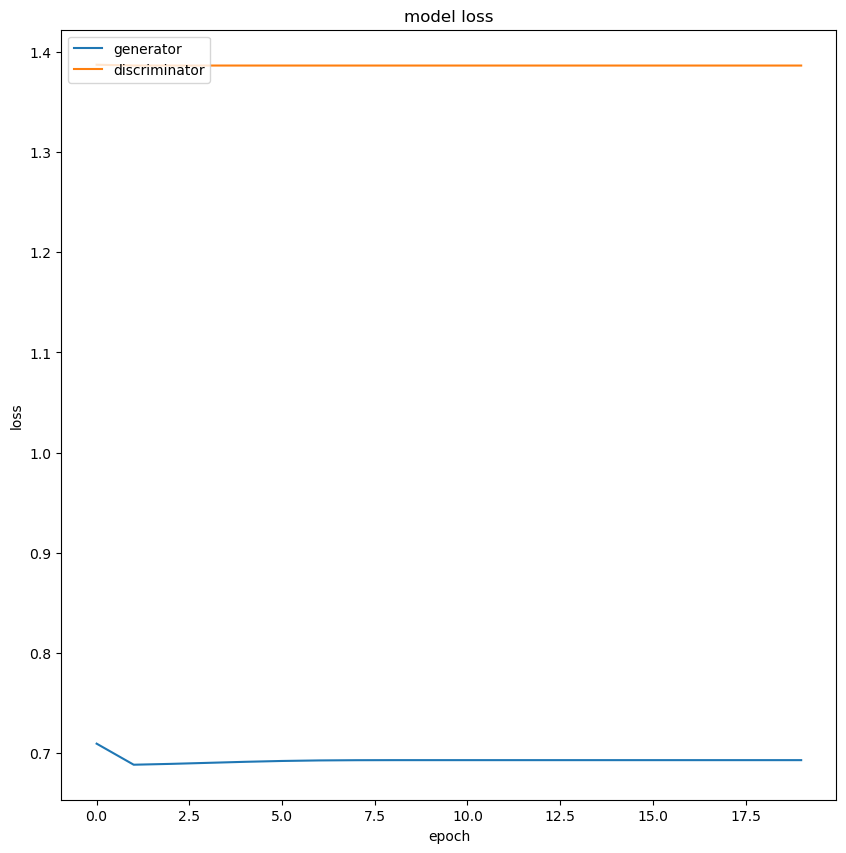

In [84]:
plt.figure(figsize=(10,10))
plt.plot(history.history['generator_loss'])
plt.plot(history.history['discriminator_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()